<a href="https://colab.research.google.com/github/Next-Sunshine/TTF0318/blob/master/TTFTest_Github_a2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@test{"skip":true}
!pip install --quiet --upgrade tensorflow_federated

In [0]:
import  collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()
#TODO(b/148678573,b/148685415):must use the ReferenceExecutor because
#it supports unbounded references and tff.sequence_* intrinsics
tff.framework.set_default_executor(tff.framework.ReferenceExecutor())

In [0]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'
hello_world()

'Hello, World!'

In [0]:
#加载MNIST数据集
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#x.dtype应该是数据类型，uint8是8位无符号整型，x.shape是在打印x的维度
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

In [0]:
#batch翻译为批，CNN是分批处理，batch_size就是每批处理的大小
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100

def get_data_for_digit(source,digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i+ BATCH_SIZE]
    output_sequence.append({
        'x':
        np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                 dtype = np.float32),
        'y':
        np.array([source[1][i] for i in batch_samples], dtype= np.int32)
    })
  return output_sequence
federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]
federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]


In [0]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

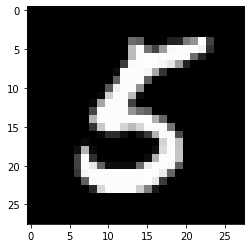

In [0]:
#查看与该批次相对应的最后一个元素相对应的图像
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28,28), cmap = 'gray')
plt.grid(False)
plt.show()

In [0]:
BATCH_SPEC = collections.OrderedDict(
    #维度设置为None表示大小未知
    x = tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y = tf.TensorSpec(shape=[None], dtype=tf.int32)
)
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

In [0]:
MODEL_SPEC = collections.OrderedDict(
    weights = tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias = tf.TensorSpec(shape=[10], dtype=tf.float32)
)
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


In [0]:
# NOTE: 'forward_pass' is defined separately from 'batch_loss'
#so that it can be later called from within another tf.function.
#Necessary because a @tf.function decorated method cannot
# invoke a @tff.tf_computation.
@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias']
  )
  return -tf.reduce_mean(
      tf.reduce_sum(
      tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1])
  )
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

In [0]:
str(batch_loss.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>> -> float32)'

In [0]:
initial_model = collections.OrderedDict(
    weights = np.zeros([784, 10], dtype=np.float32),
    bias = np.zeros([10], dtype=np.float32)
)
sample_batch = federated_train_data[5][-1]
batch_loss(initial_model, sample_batch)

2.3025854

In [0]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  #Define a group of model variables and set them to 'initial_model'
  #Must be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()                                  
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from batch_loss
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars
    
  return _train_on_batch(model_vars, batch)

In [0]:
str(batch_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>,float32> -> <weights=float32[784,10],bias=float32[10]>)'